All the information on how to use the Statmorph library can be found at https://statmorph.readthedocs.io/en/latest/

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils
import time
import statmorph
import scipy.ndimage as ndi
from astropy.convolution import convolve
from astropy.table import Table
from astropy.table import Column
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import SourceCatalog

## Paths

In [2]:
directory = './'

## Open the image

In [20]:
fits_input = fits.open(directory+'broadband_551722_yz.fits')
fits_input.info()
data=fits_input[0].data
hdr=fits_input[0].header

Filename: /Users/antoniolm/Documents/TNG-KiDSlike/testing/major_merger/broadband_551722_yz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (256, 256)   float32   


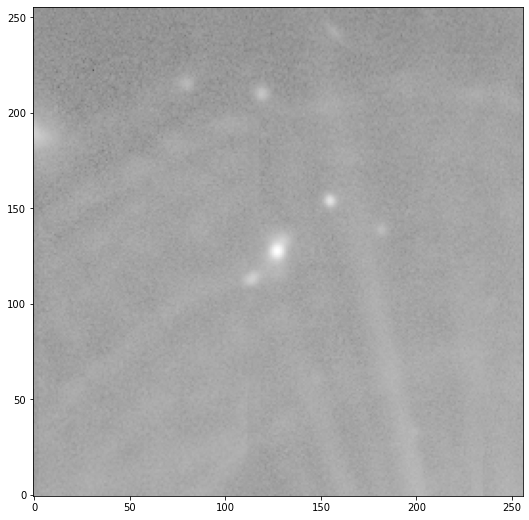

In [21]:
plt.figure(figsize=(9,9))

plt.imshow(data, cmap='gray', origin='lower',
           norm=simple_norm(data, stretch='log', log_a=10000))

plt.show()

In [22]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (25,25), filter_size=(3,3),
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [23]:
print(bkg.background_median) 

0.13766859471797943


In [24]:
print(bkg.background_rms_median)

0.03425640608376361


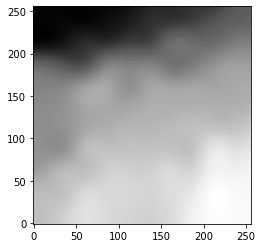

In [25]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',
           interpolation='nearest')

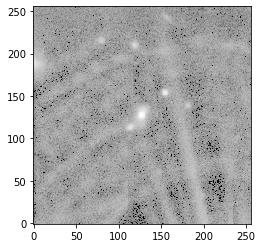

In [26]:
plt.imshow(data - bkg.background, norm=simple_norm(data, stretch='log', log_a=10000), origin='lower',
            cmap='Greys_r', interpolation='nearest')

In [27]:
gain = 2.5

## Generate a PSF

A use a simple Gaussian PSF with a FWHM of 0.77 arcsec (or 3.7 pixels)

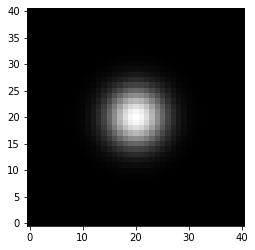

In [28]:
size = 20  # on each side from the center
sigma_psf = 3.7 #FWHM KiDS is 0.77 arcsec
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)

plt.imshow(psf, origin='lower', cmap='gray')
plt.show()

## No Need for convolving!

In [29]:
# data = convolve(data, psf)

# plt.figure(figsize=(9,9))

# plt.imshow(data, cmap='gray', origin='lower',
#            norm=simple_norm(data, stretch='log', log_a=10000))


# plt.show()

## Create a segmentation map

In [30]:
threshold = photutils.detect_threshold(data-bkg.background, 1.5)
npixels = 5
segm = photutils.detect_sources(data-bkg.background, threshold, npixels)

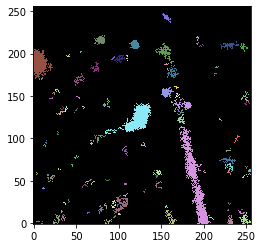

In [37]:
cmap = segm.make_cmap(seed=123)

plt.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
plt.show()

In [32]:
cat = SourceCatalog(data, segm)

tbl = cat.to_table()

tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
1,10.18468787102985,0.8459665361638298,None,9,11,0,2,6.0,0.9386018207076257,0.6219075794922329,67.02434183715376,0.7489828704826054,0.21499538,0.23951975,0.0,1.3804303,nan,16.449999323258382,nan
2,27.77078283372683,5.131234315431092,None,23,31,0,11,38.0,3.4991718204594022,1.888806075475753,67.40156900212354,0.8418018897688684,0.21482663,0.28737834,0.0,9.057407,nan,181.54697725614682,nan
3,87.69074896010311,2.521279851922198,None,83,93,0,5,24.0,2.8794054371382183,1.3902085622842335,6.102182043559471,0.8757245897738735,0.22867365,0.28735048,0.0,5.971405,nan,112.95412450608175,nan
4,160.93175115944658,7.263426085197216,None,155,168,0,16,66.0,5.128174933300821,1.9902931464447782,-60.278335192334985,0.9216132897223289,0.22789973,0.3061897,0.0,16.611635,nan,263.50117846765943,nan
5,190.00373971570318,48.75060230142035,None,171,208,0,114,1047.0,32.59500875105057,3.3192461452332136,-77.44753831858513,0.9948015122321962,0.20729558,0.42565215,0.0,293.72626,nan,1897.8060683180129,nan
6,231.43628904045238,3.909084925549803,None,228,234,0,10,46.0,3.062893044315139,1.628892049776718,-86.03258731220609,0.8468606436394044,0.2631988,0.35373586,0.0,13.314814,nan,173.1963409740551,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,119.12643569620478,209.8458765389022,None,113,125,205,215,87.0,2.4300618884420806,2.2275387194636025,-41.079457703208504,0.39966962709980297,0.13589641,0.63238055,0.0,23.79384,nan,107.26845640446888,nan


In [39]:
x, y = tbl['xcentroid'], tbl['ycentroid']

new_tbl = tbl[(x<158.)&(x>98.) & (y>98.)&(y<158.)]
new_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
71,124.83586558030107,124.9662909795824,None,100,138,108,141,614.0,8.643651077210318,3.898401174273326,50.90967844912311,0.8925172532075057,0.19726536,5.8642726,0.0,361.21228,nan,1096.243589973851,nan
92,155.48346217493986,153.8957288616398,None,150,165,148,160,106.0,2.6659286910207447,2.2647018244398316,12.55435918127725,0.5275913955702903,0.19553022,1.9780331,0.0,50.934864,nan,197.2156320602231,nan


In [50]:
index = np.argmax(new_tbl['area'])

print(new_tbl['label'][np.argmax(new_tbl['area'])])

71


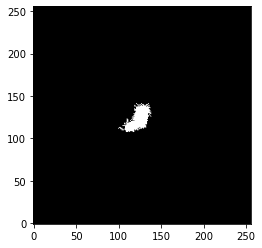

In [44]:
# Keep only the largest segment
label = new_tbl['label'][index]
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

plt.show()

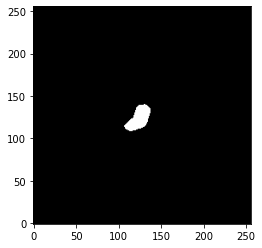

In [45]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

plt.show()

## Running Statmorph

In [46]:
start = time.time()
source_morphs = statmorph.source_morphology(
    data-bkg.background, segmap, gain=gain,psf=psf)
print('Time: %g s.' % (time.time() - start))

Time: 0.116357 s.


In [47]:
morph = source_morphs[0]

In [48]:
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

xc_centroid = 125.58568304683305
yc_centroid = 125.7419422713742
ellipticity_centroid = 0.5879366066987597
elongation_centroid = 2.426811059309378
orientation_centroid = 0.9148780049908081
xc_asymmetry = 127.19676792810552
yc_asymmetry = 127.65074402881066
ellipticity_asymmetry = 0.6091326014338253
elongation_asymmetry = 2.5584124019253496
orientation_asymmetry = 0.9094831072134444
rpetro_circ = 8.275296351588747
rpetro_ellip = 14.352620787868402
rhalf_circ = 4.033658967711675
rhalf_ellip = 7.182667568217677
r20 = 1.7600497669301622
r50 = 3.4311583880155636
r80 = 6.722949229176324
Gini = 0.5481994329928449
M20 = -1.7299493189636406
F(G, M20) = -0.047557928643614744
S(G, M20) = -0.024745516673029655
sn_per_pixel = 1.3633877082075272
C = 2.910174417462781
A = 0.09376967004122509
S = 0.06780049070731878
sersic_amplitude = 0.9471731826612616
sersic_rhalf = 7.182667568217677
sersic_n = 1.3295864031793438
sersic_xc = 127.19676792810552
sersic_yc = 127.65074402881066
sersic_ellip = 0.60913260

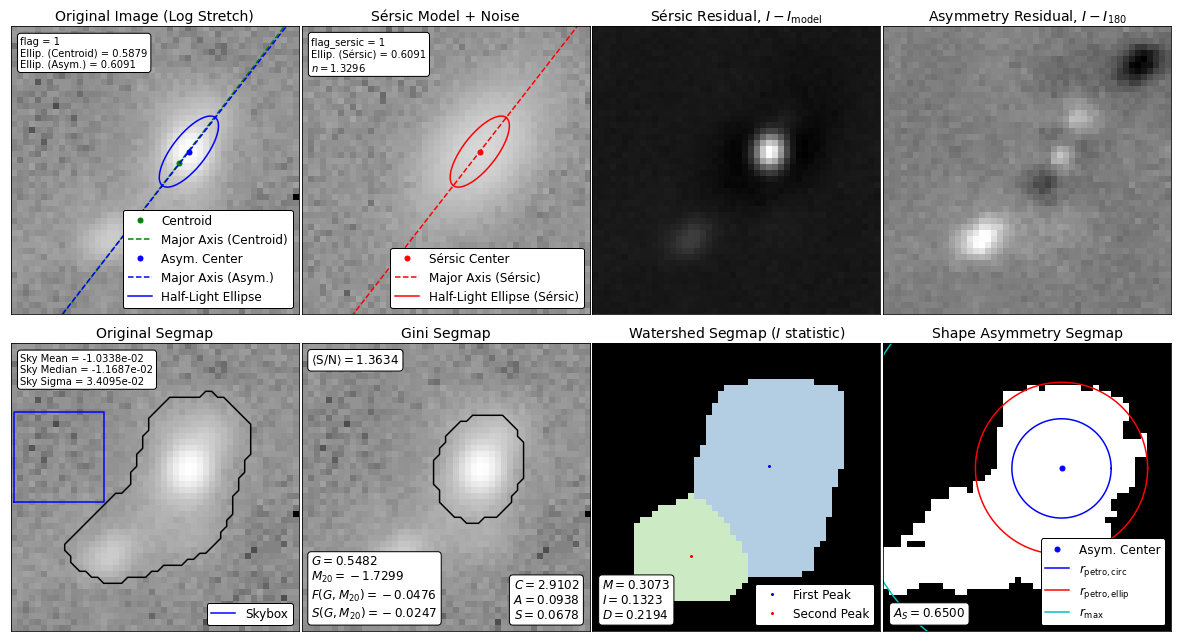

In [49]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

### Run Statmorph on a batch of images and save the parameters in a table

In [ ]:
for name in file_names:
    
    start = time.time()
    
    try:
        fits_input = fits.open(directory+name)
        fits_input.info()
        data=fits_input[0].data
        hdr=fits_input[0].header

        data = sub_background(data, show_plots=True)

    
        segmap = segmentation_map(data, show_plots=True)
        
#     except:
#         print('I skip this galaxy: ', name, '\n')
#         continue
    
#     try:
        source_morphs = statmorph.source_morphology(
            data, segmap, gain=gain,psf=psf)


        morph = source_morphs[0]
        new_row = [name, morph.xc_centroid, morph.yc_centroid, morph.ellipticity_centroid, morph.elongation_centroid,
               morph.orientation_centroid, morph.xc_asymmetry, morph.yc_asymmetry, morph.ellipticity_asymmetry, 
               morph.elongation_asymmetry, morph.orientation_asymmetry, morph.r20,morph.r50,morph.r80,
               morph.rhalf_circ, morph.rhalf_ellip, morph.rmax_circ, morph.rmax_ellip, morph.rpetro_circ,
               morph.rpetro_ellip, morph.concentration, morph.asymmetry, morph.smoothness, morph.m20, morph.gini,
               morph.gini_m20_bulge, morph.gini_m20_merger, morph.deviation, morph.shape_asymmetry, 
               morph.outer_asymmetry, morph.multimode, morph.sn_per_pixel, morph.flux_circ, morph.flux_ellip,
               morph.intensity, morph.sersic_xc, morph.sersic_yc, morph.sersic_amplitude, morph.sersic_ellip,
               morph.sersic_n, morph.sersic_rhalf, morph.sersic_theta, morph.sky_mean, morph.sky_median, 
               morph.sky_sigma, morph.nx_stamp, morph.ny_stamp, morph.xmax_stamp, morph.xmin_stamp,
               morph.ymax_stamp, morph.ymin_stamp, morph.flag, morph.flag_sersic
              ]

        table.add_row(new_row)
        
    except:
        print('I skip this galaxy: ',name,'\n')
        continue

    print('Time: %g s.' % (time.time() - start))

## Various

In [114]:
morph.asymmetry
morph.concentration
morph.deviation
morph.ellipticity_asymmetry
morph.ellipticity_centroid
morph.elongation_asymmetry
morph.elongation_centroid
morph.flux_circ
morph.flux_ellip
morph.gini
morph.gini_m20_bulge
morph.gini_m20_merger
morph.intensity
morph.m20
morph.multimode
morph.nx_stamp
morph.ny_stamp
morph.orientation_asymmetry
morph.orientation_centroid
morph.outer_asymmetry
morph.r20
morph.r50
morph.r80
morph.rhalf_circ
morph.rhalf_ellip
morph.rmax_circ
morph.rmax_ellip
morph.rpetro_circ
morph.rpetro_ellip
morph.sersic_amplitude
morph.sersic_ellip
morph.sersic_n
morph.sersic_rhalf
morph.sersic_theta
morph.sersic_xc
morph.sersic_yc
morph.shape_asymmetry
morph.sky_mean
morph.sky_median
morph.sky_sigma
morph.smoothness
morph.sn_per_pixel
morph.xc_asymmetry
morph.xc_centroid
morph.xmax_stamp
morph.xmin_stamp
morph.yc_asymmetry
morph.yc_centroid
morph.ymax_stamp
morph.ymin_stamp
morph.flag
morph.flag_sersic

0

In [156]:
col_names = ('ID','xc_centroid','yc_centroid', 'ellipticity_centroid', 'elongation_centroid', 'orientation_centroid',
         'xc_asymmetry', 'yc_asymmetry','ellipticity_asymmetry', 'elongation_asymmetry', 'orientation_asymmetry',
         'r20','r50','r80','rhalf_circ','rhalf_ellip','rmax_circ','rmax_ellip','rpetro_circ','rpetro_ellip',
         'C','A','S','M20','Gini', 'F(G,M20)', 'S(G,M20)', 'deviation', 'shape_asymmetry','outer_asymmetry',
         'multimode','sn_per_pixel','flux_circ','flux_ellip','intensity',
         'sersic_xc','sersic_yc','sersic_amplitude', 'sersic_ellip','sersic_n','sersic_rhalf','sersic_theta',
         'sky_mean','sky_median','sky_sigma',
         'nx_stamp','ny_stamp','xmax_stamp','xmin_stamp','ymax_stamp','ymin_stamp',
        'flag', 'flag_sersic'
        )

t = Table(names=col_names)
t['ID'] = Column(name='ID', dtype='str')

In [158]:
t.add_row(a)

In [159]:
t

ID,xc_centroid,yc_centroid,ellipticity_centroid,elongation_centroid,orientation_centroid,xc_asymmetry,yc_asymmetry,ellipticity_asymmetry,elongation_asymmetry,orientation_asymmetry,r20,r50,r80,rhalf_circ,rhalf_ellip,rmax_circ,rmax_ellip,rpetro_circ,rpetro_ellip,C,A,S,M20,Gini,"F(G,M20)","S(G,M20)",deviation,shape_asymmetry,outer_asymmetry,multimode,sn_per_pixel,flux_circ,flux_ellip,intensity,sersic_xc,sersic_yc,sersic_amplitude,sersic_ellip,sersic_n,sersic_rhalf,sersic_theta,sky_mean,sky_median,sky_sigma,nx_stamp,ny_stamp,xmax_stamp,xmin_stamp,ymax_stamp,ymin_stamp,flag,flag_sersic
str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
name_code,157.3893317511049,121.30740903884127,0.32029018213477545,0.1551522591067741,0.19160695427797958,1.1836452316753991,1.2370220220126273,8666.128848703593,8666.128848703594,0.54317602576636,-0.21027314712434508,-0.0020692525593728472,0.7328667869206796,-1.5310325040868293,1.0,194.0,194.0,-0.4177011168256745,-0.6953135854787489,0.38249759950306866,22.131080130431307,42.41955241051065,80.0897508882391,42.055457867630196,44.48019568045921,125.57571534926569,128.42783250271876,107.3520195931731,114.14304095614362,0.05159898604980519,0.44220208305721925,1.4317296809509419,178.64349385085103,2.439791162379436,152.59608044563475,115.70192792942363,0.5066768961049111,0.08068443834781647,0.08056288957595825,0.02707844227552414,-0.046394609113095765,0.633152961730957,147.23718668178114,157.3893317511049,238.0,45.0,117.78347771345625,121.30740903884127,224.0,31.0,1.0,0.0


In [151]:
a = ['name_code', morph.xc_centroid,morph.yc_centroid,morph.deviation,
morph.ellipticity_asymmetry,
morph.ellipticity_centroid,
morph.elongation_asymmetry,
morph.elongation_centroid,
morph.flux_circ,
morph.flux_ellip,
morph.gini,
morph.gini_m20_bulge,
morph.gini_m20_merger,
morph.intensity,
morph.m20,
morph.multimode,
morph.nx_stamp,
morph.ny_stamp,
morph.orientation_asymmetry,
morph.orientation_centroid,
morph.outer_asymmetry,
morph.r20,
morph.r50,
morph.r80,
morph.rhalf_circ,
morph.rhalf_ellip,
morph.rmax_circ,
morph.rmax_ellip,
morph.rpetro_circ,
morph.rpetro_ellip,
morph.sersic_amplitude,
morph.sersic_ellip,
morph.sersic_n,
morph.sersic_rhalf,
morph.sersic_theta,
morph.sersic_xc,
morph.sersic_yc,
morph.shape_asymmetry,
morph.sky_mean,
morph.sky_median,
morph.sky_sigma,
morph.smoothness,
morph.sn_per_pixel,
morph.xc_asymmetry,
morph.xc_centroid,
morph.xmax_stamp,
morph.xmin_stamp,
morph.yc_asymmetry,
morph.yc_centroid,
morph.ymax_stamp,
morph.ymin_stamp,
morph.flag,
morph.flag_sersic
    ]

# a.append('name_code')

# a.append(morph.xc_centroid,morph.yc_centroid)

a

['name_code',
 157.3893317511049,
 121.30740903884127,
 0.32029018213477545,
 0.1551522591067741,
 0.19160695427797958,
 1.1836452316753991,
 1.2370220220126273,
 8666.128848703593,
 8666.128848703594,
 0.54317602576636,
 -0.21027314712434508,
 -0.0020692525593728472,
 0.7328667869206796,
 -1.5310325040868293,
 1.0,
 194,
 194,
 -0.4177011168256745,
 -0.6953135854787489,
 0.38249759950306866,
 22.131080130431307,
 42.41955241051065,
 80.0897508882391,
 42.055457867630196,
 44.48019568045921,
 125.57571534926569,
 128.42783250271876,
 107.3520195931731,
 114.14304095614362,
 0.05159898604980519,
 0.44220208305721925,
 1.4317296809509419,
 178.64349385085103,
 2.439791162379436,
 152.59608044563475,
 115.70192792942363,
 0.5066768961049111,
 0.08068444,
 0.08056289,
 0.027078442,
 -0.046394609113095765,
 0.63315296,
 147.23718668178114,
 157.3893317511049,
 238,
 45,
 117.78347771345625,
 121.30740903884127,
 224,
 31,
 1,
 0]